## K 近邻算法
k 近邻算法 (k-nearest neighbor, K-NN) 是一种基本分类与回归方法，在机器学习中，常用于分类问题，由 Cover 和 Hart 提出。
k 近邻算法没有显示的学习过程，实际上是利用给定的训练数据集对特征向量空间进行划分，并将分好的特征空间作为模型。
k 近邻算法的三个基本要素为：
* 距离的度量
* k 值的选择
* 分类决策规则

## 学习算法
* 根据给定的距离度量，在训练集中找出与待分类的点 x 最邻近的 k 个点。
* 在得到的 k 个点中根据分类决策规则（通常为多数表决）决定 x 的类别
特殊情况，当 k 为1时，算法称为最近邻算法。

## 距离度量
特征空间中两个实例点的距离是两个实例点相似程度的反应，常用的距离度量有：欧氏距离（L2），曼哈顿距离（L1）等，更一般的$ L_p $距离。
$ L_p $ 距离定义：
$$ L_p(x_i,x_j)=(\sum_{l=1}^n\mid x_i^{(l)}-x_j^{(l)}\mid^p)^{\frac1p} $$
$ p\geq1 $. 当 p=2 时，称为欧氏距离（L2），P=1 时，称为曼哈顿距离（L1）。
<font color=red> 注意：不同的距离度量所确定的最近邻点是不同的。</font>

## K 值选择
k 如果选值太小，就相当于用较小的邻域中的训练实例进行预测，这样学习的近似误差会减小，但是估计误差会增大，即在训练集上的误差会很小，在测试集上的误差会增大，也就是过拟合。这是因为如果 k 值太小，预测结果会对近邻的实例点特别敏感，如果近邻的实例点碰巧是噪音，那预测结果就会出错。从模型的复杂度来说，k 值选得越小，那模型就变得越复杂。

相对的如果 k 取值很大，就相当于用较大的邻域中的训练实例进行预测，其优点是可以减小估计误差，但这样较远的点也会对预测结果产生影响，近似误差就会增大，也就是说欠拟合，从模型复杂度来说模型就变得很简单。

所以对于 k 值的选择一般是选择一个比较小的数值，如 7，但是通常会采用交叉验证法来选择 k 的值。

## 分类决策规则
分类决策规则就是说在选出了 x 的 k 个点的邻域后，如何去判定 x 的类别，常用的方法为多数表决规则，即投票。
多数表决规则等价于经验风险最小化，推理如下：
误分类的概率：
$$ P(Y\neq f(X))=1-P(Y=f(x)) $$
对给定的实例 x, 其最近邻的 k 个训练实例点构成集合 $ N_k(x) $。如果涵盖 $ N_k(x) $的区域类别是 $ c_j $,那么误分类率：
$$ \frac{1}{k}\sum_{x_i\in N_k(x)}I(y_i\neq c_j)=1-\frac{1}{k}\sum_{x_i\in N_k(x)}I(y_i=c_j)$$
要使误分类率最小即经验风险最小，就要使 $\sum_{x_i\in N_k(x)}I(y_i=c_j) $最大，所以多数表决等价于经验风险最小化。

## 导入相关包并获得数据
使用 Iris 数据集

In [1]:
import numpy as np
from sklearn import datasets
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 加载鸢尾花数据集
iris = datasets.load_iris()

X, y = iris.data, iris.target
X.shape, y.shape

((150, 4), (150,))

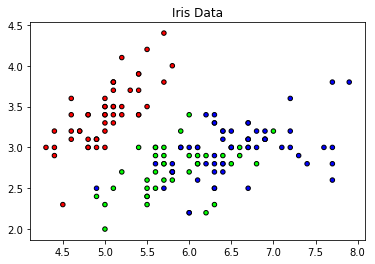

In [3]:
# 对数据进行可视化，采用二维
X = X[:, :2]

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

plt.figure()
plt.title("Iris Data")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=20)
plt.show()

## 定义 K-NN 分类器类
为了避免不同特征的值相差很大对分类结果产生影响，对数据进行归一化处理，归一化处理公式采用 max-min 归一化公式

本案例中 K-NN 的搜索的时间复杂度为 O(n)， 数据集较小，计算量不大，未使用加速搜索的算法，若需要快速搜索可以采用 KD树算法进行搜索

In [4]:
class K_NN():
    def __init__(self, k=15):
        self.x_col_max = None
        self.x_col_min = None
        self.X = None
        self.y = None
        self.k = k
    
    def fit(self, x_train, y_train):
        self.x_col_max = x_train.max(axis=0)
        self.x_col_min = x_train.min(axis=0)
        
        # 对数据归一化处理，避免特征值差异太大产生的特征不平衡问题
        self.X = (x_train - self.x_col_min) / (self.x_col_max - self.x_col_min)
        self.y = y_train
        
    def predict(self, x_test):
        if self.X is None or self.y is None:
            raise NameError("模型未训练")
        
        # 对数据归一化处理，避免特征值差异太大产生的特征不平衡问题
        x_test = (x_test - self.x_col_min) / (self.x_col_max - self.x_col_min)
        
        num_test = x_test.shape[0]
        num_train = self.X.shape[0]
        dists = np.zeros((num_test, num_train))
        
        # 使用向量化的手段，避免使用循环，加速计算
        dists = np.sqrt(-2 * np.dot(x_test, self.X.T) + np.sum(np.square(self.X), axis=1) + np.transpose([np.sum(np.square(x_test), axis=1)]))
        
        y_predict = np.zeros(num_test)
        # 选出K个距离最近的点
        for i in range(num_test):
            closest_y = []
            closest_y = self.y[np.argsort(dists[i])[:self.k]]
            y_predict[i] = np.argmax(np.bincount(closest_y))
        
        return y_predict

## 训练模型并进行预测，绘制决策边界

In [5]:
# 实例化模型并训练
knn = K_NN(k=7)
knn.fit(X, y)

In [6]:
# 构建绘图区域数据
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.2), np.arange(y_min, y_max, 0.2))

# 使用训练好的模型预测
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])

c:\developtool\python3.6.4\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in sqrt


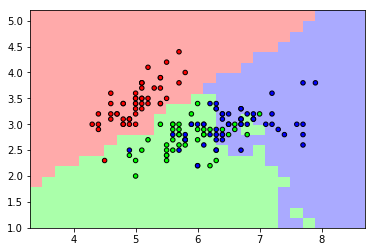

In [7]:
# 绘制出模型的分类效果图
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()